# <center>ASSIGNMENT - Freezing of Gait</center>

In [1]:
import os
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from data_dictionary import data_dict

from imblearn.over_sampling import RandomOverSampler
from featurewiz import featurewiz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [2]:
PATH = os.path.join(".\\", "data", "dataset")
COLUMN_NAMES = ['time-of-sample', 'ank-f-acc', 'ank-v-acc', 'ank-l-acc', 'upleg-f-acc', 'upleg-v-acc', 'upleg-l-acc', 'trnk-f-acc', 'trnk-v-acc', 'trnk-l-acc', 'annot']

## LOADING DATASET

* The dataset was loaded from 10 .txt files.
* Each text file was named S\<ss>R\<rr>.txt.
* The naming format indicates that the dataset belongs to user \<ss> in recording run \<rr>.
* While loading the dataset, the values for different nuns of a particular user were combined.
* Users 4 and 10 did not show any freezing of gait in their recordings, so their data should be excluded.
* Dropping the rows where 'annot' = 0 as it is not part of the experiment.

In [3]:
dataset = pd.DataFrame()
for filename in os.listdir(PATH):
    if filename[1:3] not in ['04', '10']:
        df = pd.read_csv(os.path.join(PATH, filename), names=COLUMN_NAMES, delimiter=' ')
        df['user'] = int(filename[1:3])
        df['run'] = int(filename[4:6])
        dataset = pd.concat([dataset, df])

dataset = dataset[dataset['annot'] != 0]

## DATA EXPLORATION AND VISUALIZATION

Column name description are as follows:
| <center>Variable</center> | <center>Description</center> |
| :-- | :-- |
| time-of-sample | Time of sample in millisecond |
| ank-f-acc | Ankle (shank) - Horizontal forward acceleration [mg] |
| ank-v-acc | Ankle (shank) - Vertical acceleration [mg] |
| ank-l-acc | Ankle (shank) - Horizontal lateral acceleration [mg] |
| upleg-f-acc | Upper leg (thigh) - Horizontal forward acceleration [mg] |
| upleg-v-acc | Upper leg (thigh) - Vertical acceleration [mg] |
| upleg-l-acc | Upper leg (thigh) - Horizontal lateral acceleration [mg] |
| trunk-f-acc | Trunk - Horizontal forward acceleration [mg] |
| trunk-v-acc | Trunk - Vertical acceleration [mg] |
| trunk-l-acc | Trunk - Horizontal lateral acceleration [mg] |
| annot | Annotations (see Annotations section) |
| user | Data belonging to a particular user |
| run | Data belonging to a recording run |

### Annotations
* 0 : not part of the experiment. For instance the sensors are installed on the user or the user is performing activities unrelated to the experimental protocol.
* 1 : Experiment, no freeze (can be any of stand, walk, turn)
* 2 : Freeze


In [4]:
dataset.head()

,time-of-sample,ank-f-acc,ank-v-acc,ank-l-acc,upleg-f-acc,upleg-v-acc,upleg-l-acc,trnk-f-acc,trnk-v-acc,trnk-l-acc,annot,user,run
47999,750000,-30,990,326,-45,972,181,-38,1000,29,1,1,1
48000,750015,-30,1000,356,-18,981,212,-48,1028,29,1,1,1
48001,750031,-20,990,336,18,981,222,-38,1038,9,1,1,1
48002,750046,-20,1000,316,36,990,222,-19,1038,9,1,1,1
48003,750062,0,990,316,36,990,212,-29,1038,29,1,1,1


No null values are present in the dataset.

In [5]:
dataset.isnull().sum()

time-of-sample    0
ank-f-acc         0
ank-v-acc         0
ank-l-acc         0
upleg-f-acc       0
upleg-v-acc       0
upleg-l-acc       0
trnk-f-acc        0
trnk-v-acc        0
trnk-l-acc        0
annot             0
user              0
run               0
dtype: int64

In [6]:
def plot_user_histogram(user):

    cols = ['ank-f-acc', 'ank-v-acc', 'ank-l-acc', 'upleg-f-acc',
        'upleg-v-acc', 'upleg-l-acc', 'trnk-f-acc', 'trnk-v-acc', 'trnk-l-acc']

    df_sample = dataset[dataset['user'] == user]

    fig, ax = plt.subplots(3, 3, figsize=(20,10))
    fig.suptitle(f'User {user} : ' + 'Histogram of Features', size=20)
    for i in range(3):
        for j in range(3):
            col_name = cols[i * 3 + j]
            plot_data_1 = df_sample[col_name][df_sample['annot'] == 1]
            plot_data_2 = df_sample[col_name][df_sample['annot'] == 2]
            ax[i,j].hist(plot_data_1, label="No Freeze", edgecolor='black', bins=100)
            ax[i,j].hist(plot_data_2, label='Gait Freeze', edgecolor='black', bins=100)
            ax[i,j].legend()
            ax[i,j].set_title(f'{str(i*3+j+1)}) ' + data_dict[col_name], size=15)
            ax[i,j].set_ylabel('Frequency', size=12)
            ax[i,j].set_xlabel('Acceleration value bins', size=12)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

### Histogram Observations: User 08
* The plots numbered 5 and 7 are negatively skewed for the 'No Freeze' state.
* The histograms show similar nature of distribution for the No Freeze and Freeze Gait states, which means that features show less Separability.
* The plots for Trunk accelerations in 'Gait Freeze' are bell-shaped and appear to be normally distributed.
* The plots numbered 5 and 8 are negatively skewed.

NOTE : The plots for other users and the overall dataset might be different.

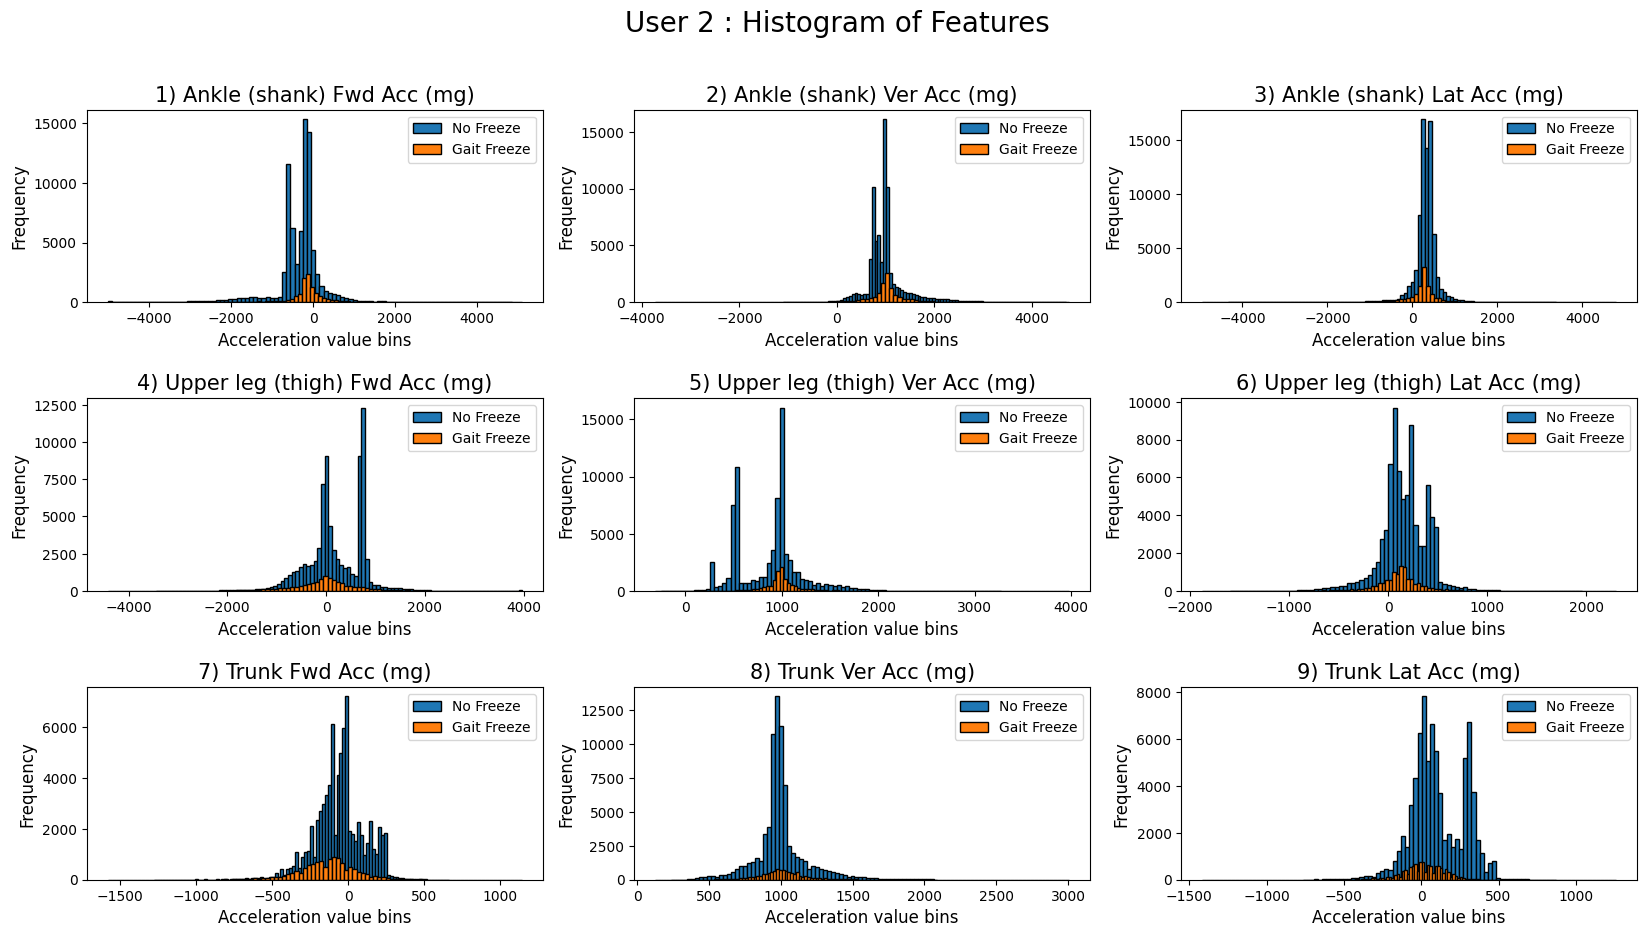

In [7]:
sample_user = random.choice(list(dataset['user'].unique()))
plot_user_histogram(sample_user)

### Histogram Observations: Overall Dataset
* The plots don't appear to be skewed.
* The histograms show similar nature of distribution for the No Freeze and Freeze Gait states, which means that features show less Separability.
* The plots for Trunk accelerations in 'Gait Freeze' have Multimodal distribution.

NOTE : Based on the above observations, distribution for User 08 and the overall appear to be similar.

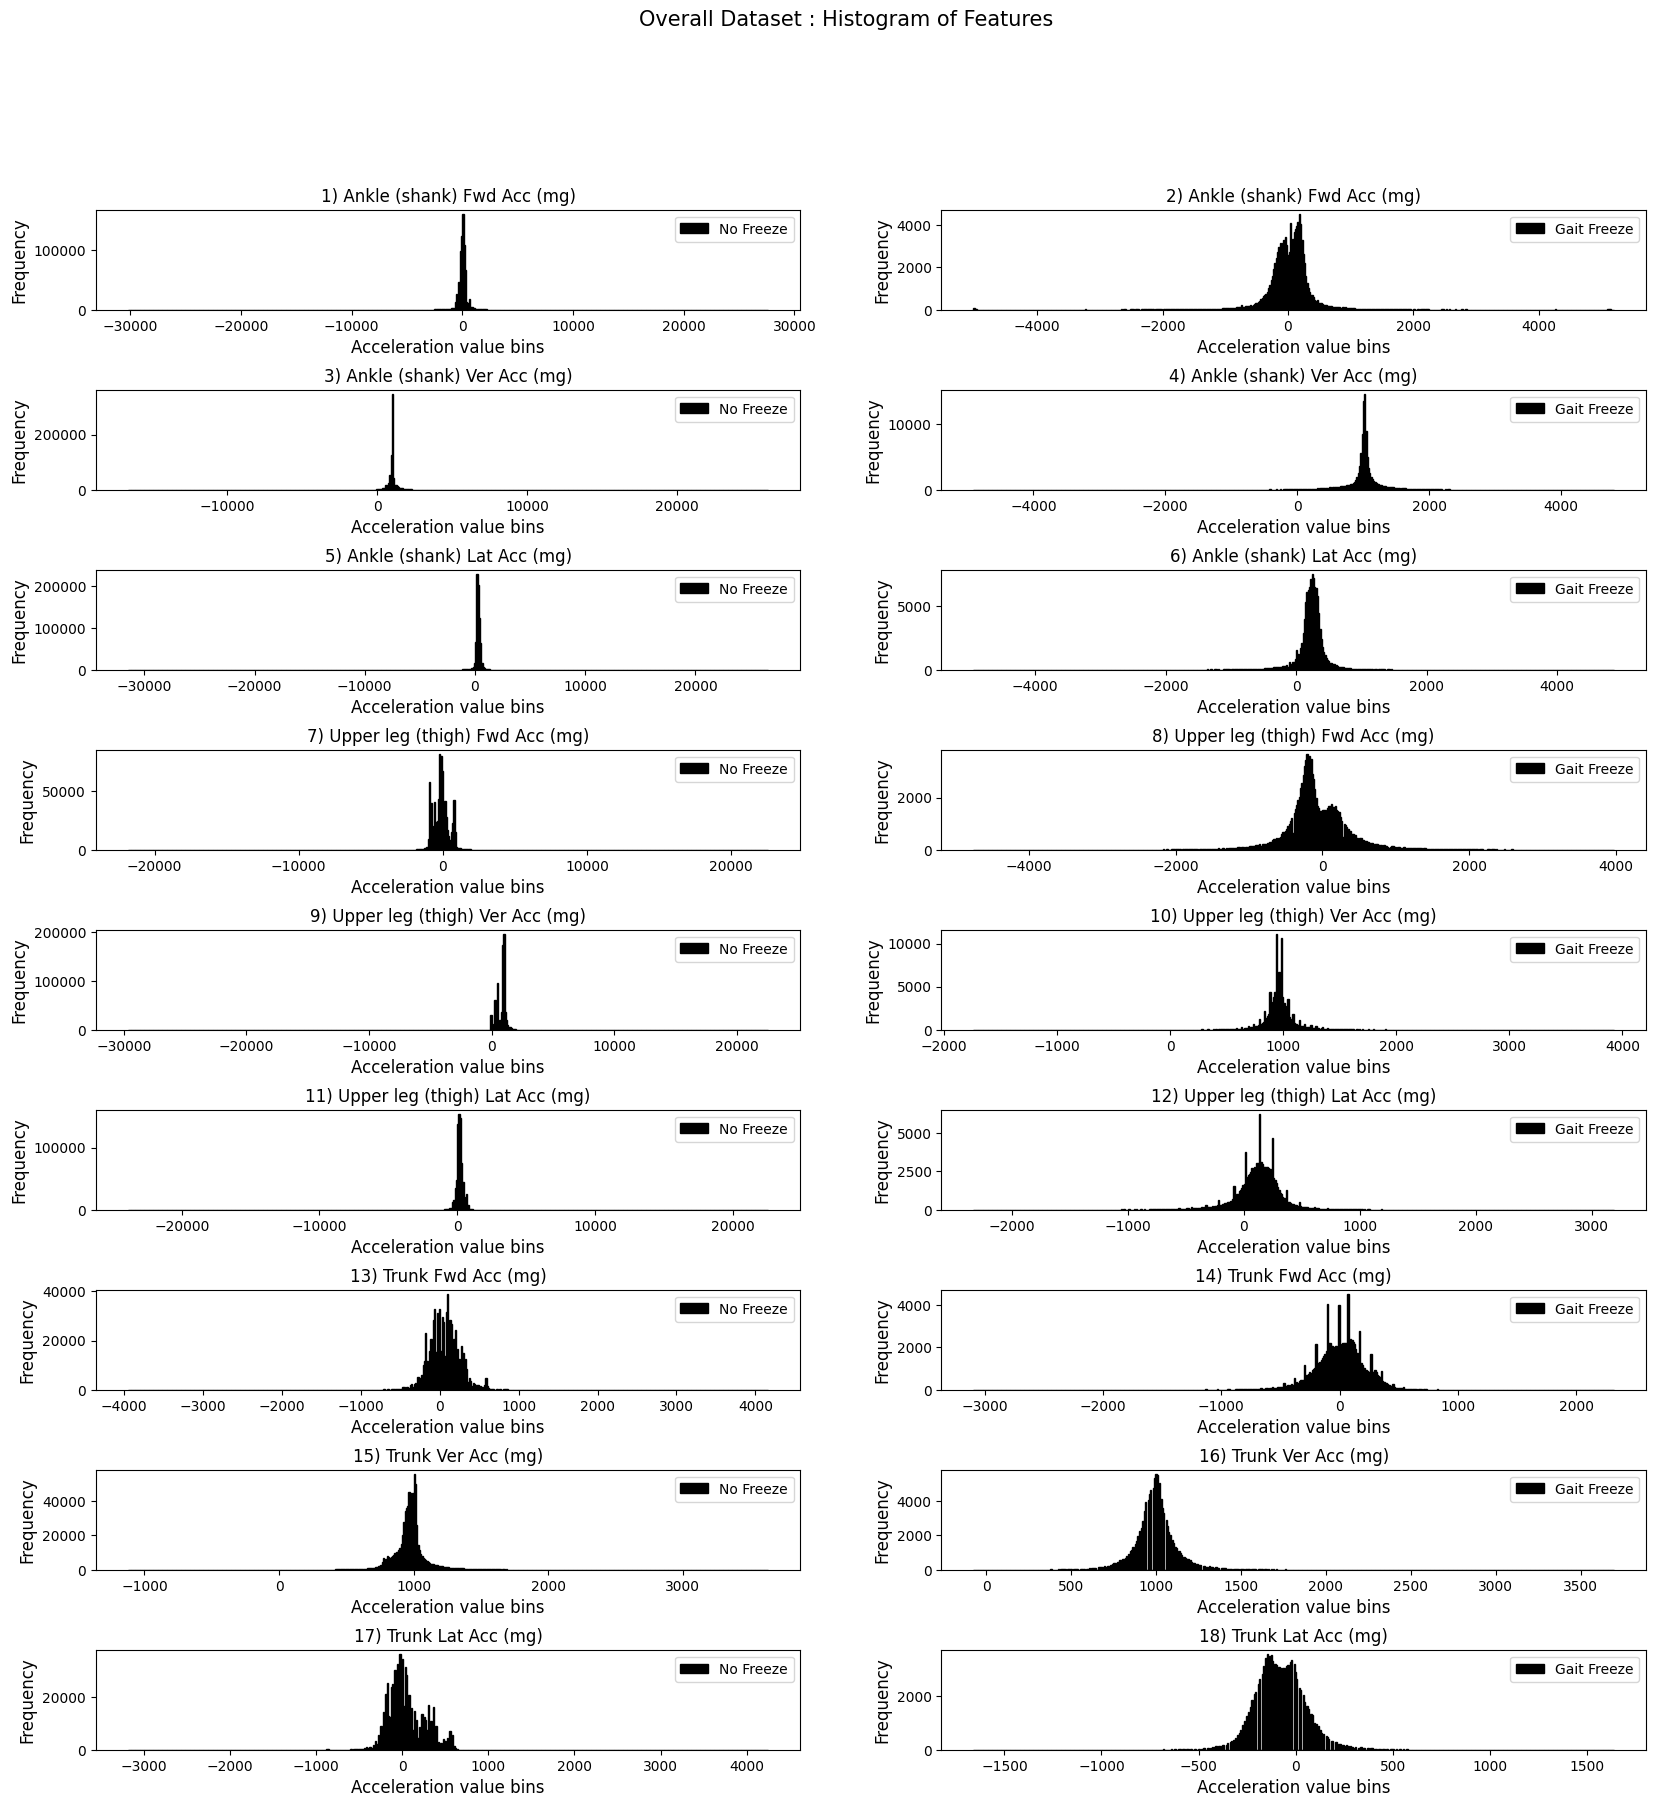

In [8]:
cols = ['ank-f-acc', 'ank-v-acc', 'ank-l-acc', 'upleg-f-acc',
    'upleg-v-acc', 'upleg-l-acc', 'trnk-f-acc', 'trnk-v-acc', 'trnk-l-acc']

fig, ax = plt.subplots(9, 2, figsize=(20,20))
fig.suptitle(f'Overall Dataset : ' + 'Histogram of Features', size=15)

for i in range(9):
    col_name = cols[i]
    for j in range(2):
        plot_data = dataset[col_name][dataset['annot'] == j+1]
        if j == 0:
            label = 'No Freeze'
        else:
            label = "Gait Freeze"
        ax[i,j].hist(plot_data, edgecolor='black', label=label, color='black', bins=500)
        ax[i,j].set_title(f'{str(i*2+j+1)}) ' + data_dict[col_name], size=12)
        ax[i,j].set_ylabel('Frequency', size=12)
        ax[i,j].set_xlabel('Acceleration value bins', size=12)
        ax[i,j].legend()

plt.subplots_adjust(hspace=0.8)
plt.show()

#### Aggregating the Dataframe for a time-series plot

In [9]:
agg_func = {
    'ank-f-acc': 'mean',
    'ank-v-acc': 'mean',
    'ank-l-acc': 'mean',
    'upleg-f-acc': 'mean',
    'upleg-v-acc': 'mean',
    'upleg-l-acc': 'mean',
    'trnk-f-acc': 'mean',
    'trnk-v-acc': 'mean',
    'trnk-l-acc': 'mean',
    'annot': 'mean',
}

agg_df = dataset[cols + ['annot', 'time-of-sample']][dataset['annot'] != 0].groupby('time-of-sample').agg(agg_func)

### Time-series Observations:
* No gait freeze was observed during the first 8 minutes of the experiment.
* The first occurrence of gait freeze was noticed 8 minutes into the experiment.
* There were no more instances of gait freeze between the 8th and 15th minute of the experiment.
* Another freeze was noticed around the 15-minute mark of the experiment.
* There were no more freezes until 20 minutes into the experiment.
* A few instances of gait freeze were observed between the 20th and 25th minute of the experiment.
* The maximum number of gait freezes occurred between the 25th and 33rd minute of the experiment.
* After the 33rd minute of the experiment, there were minimal occurrences of gait freeze.

NOTE : The aggregated plot shows 'Gait Freeze' state when a minimum of 40% datapoints have 'Gait Freeze'.

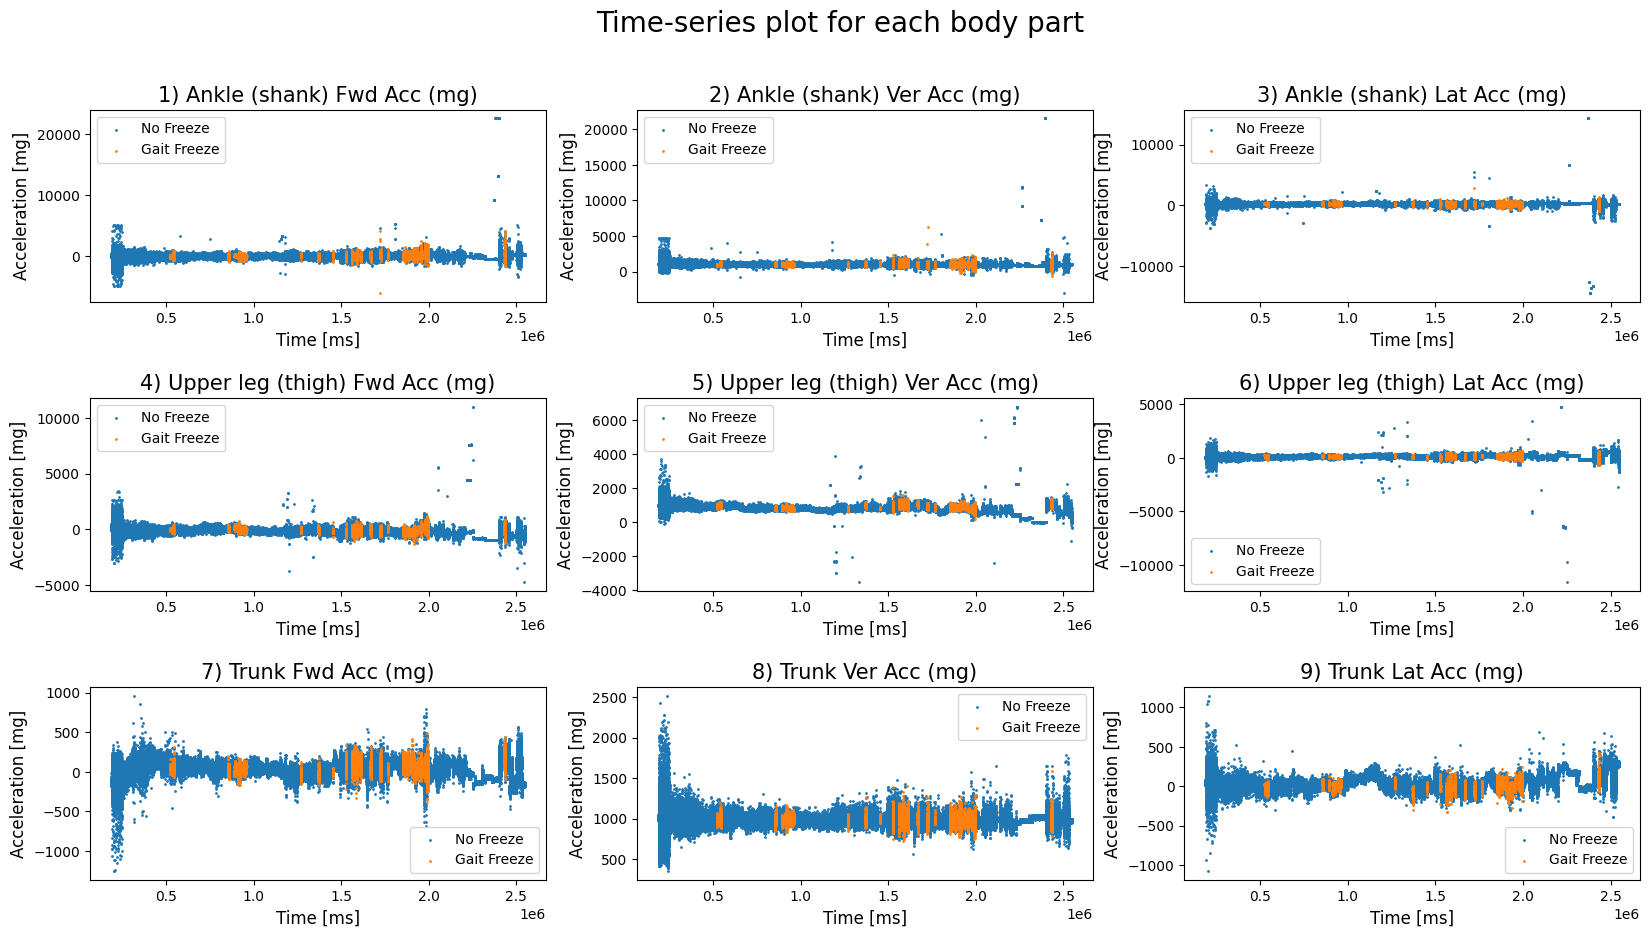

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20,10))
fig.suptitle(f'Time-series plot for each body part', size=20)

for i in range(3):
    for j in range(3):
        col_name = cols[i * 3 + j]
        ax[i,j].scatter(list(agg_df[col_name][agg_df['annot'] < 1.4].index.values), agg_df[col_name][agg_df['annot'] < 1.4], label='No Freeze', s=1)
        ax[i,j].scatter(list(agg_df[col_name][agg_df['annot'] >= 1.4].index.values), agg_df[col_name][agg_df['annot'] >= 1.4], label='Gait Freeze', s=1)
        ax[i,j].legend()
        ax[i,j].set_title(f'{str(i*3+j+1)}) ' + data_dict[col_name], size=15)
        ax[i,j].set_ylabel('Acceleration [mg]', size=12)
        ax[i,j].set_xlabel('Time [ms]', size=12)
        

plt.subplots_adjust(hspace=0.5)
plt.show()

## FEATURE SELECTION

* Dropping the columns: user, run.
* Shuffling the dataset.

In [11]:
dataset.drop(columns=['user', 'run'], inplace=True)
dataset = dataset.sample(frac=1).reset_index(drop=True)

### Correlation Heatmap Observations:
* Variables don't have a high a correlation.
* Max absolute correlation value observed is 0.37 between the Upper Leg Vertical Acceleration and Trunk Lateral Acceleration.

<Axes: >

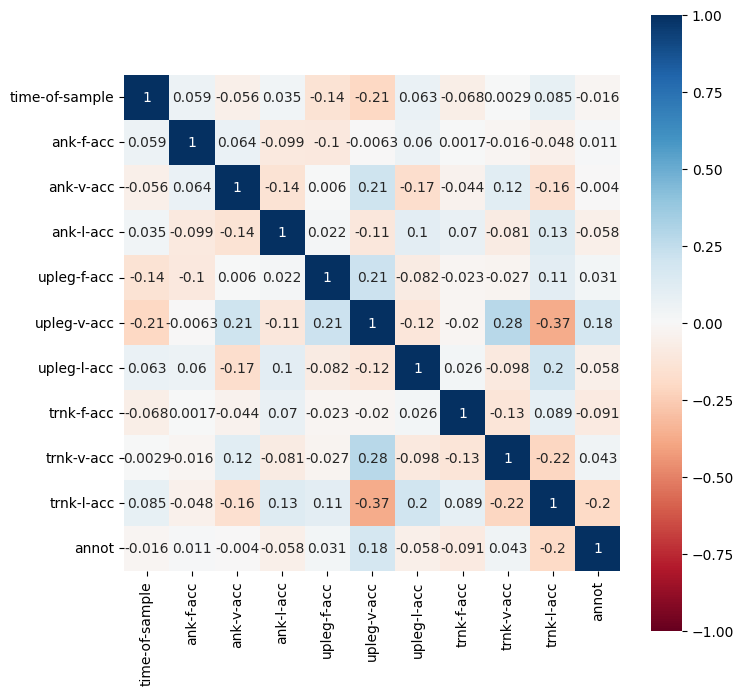

In [12]:
plt.figure(figsize=(8,8))
sns.heatmap(dataset.corr(), cmap='RdBu', annot=True, square=True, vmin=-1, vmax=1)

Using Featurewiz for feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (865631, 11)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random samp

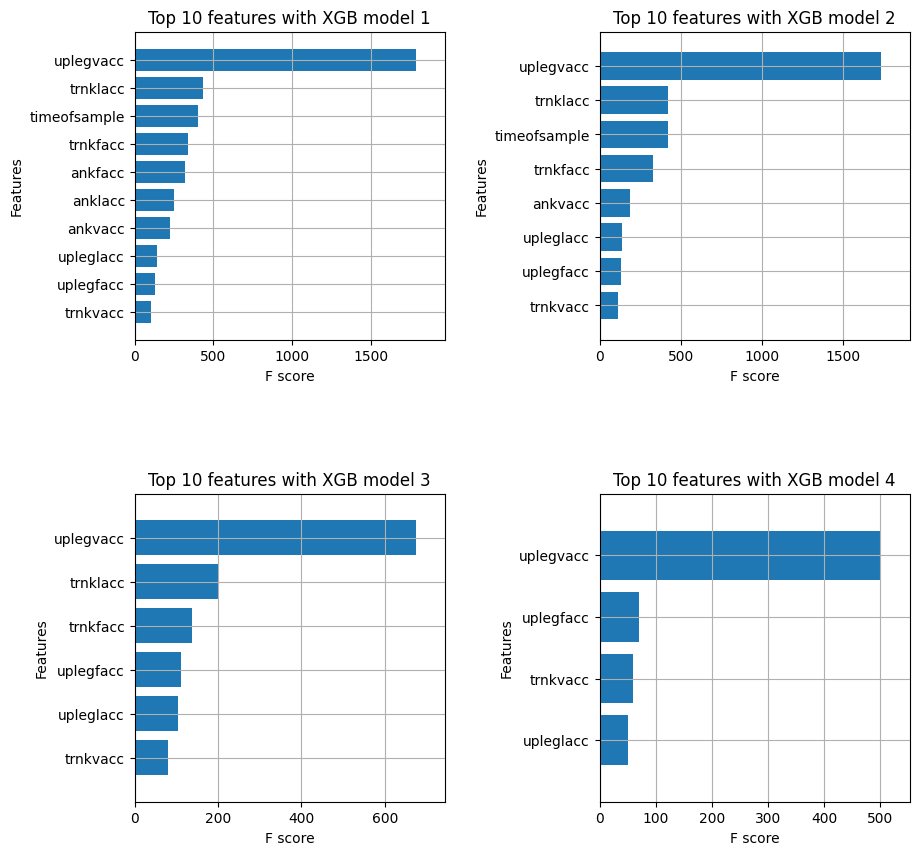

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['uplegvacc', 'trnklacc', 'timeofsample', 'trnkfacc', 'ankfacc', 'uplegfacc']
Total Time taken for featurewiz selection = 12 seconds
Output contains a list of 6 important features and a train dataframe


In [13]:
features, train = featurewiz(dataset, 'annot', corr_limit=0.7, verbose=2)

Selected Features

In [14]:
features

['upleg-v-acc',
 'trnk-l-acc',
 'time-of-sample',
 'trnk-f-acc',
 'ank-f-acc',
 'upleg-f-acc']

### Final dataframe for Model Training
NOTE :
* 'annot' = 0 represents 'No Freeze' state.
* 'annot' = 1 represents 'Gait Freeze' state.

In [15]:
train.head()

,upleg-v-acc,trnk-l-acc,time-of-sample,trnk-f-acc,ank-f-acc,upleg-f-acc,annot
0,0,-77,796875,-339,272,0,0
1,842,67,1428781,77,-212,-63,1
2,981,145,418890,194,-111,-154,0
3,1564,-174,638296,-126,1444,1100,0
4,879,-67,943250,29,101,63,0


## DATA PREPROCESSING

### Checking class distribution in the final dataset
* Gait freeze being observed is a minority class as it constitutes only 12.7% of the dataset.
* The dataset is moderately imbalanced.
* For the classifiers to work correctly, sampling needs to be done.

In [16]:
train['annot'].value_counts()/len(train)

0    0.872018
1    0.127982
Name: annot, dtype: float64

In [17]:
X = train.drop('annot', axis=1)
y = train['annot']

Oversampling the dataset so that the ratio of Minority to Majority class is 0.5

In [18]:
X, y = RandomOverSampler(sampling_strategy=0.5).fit_resample(X, y)

Splitting into training and testing set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## MODEL TRAINING

There are several machine learning models that can be used for this assignment:
* Logistic Regression
* Decision Trees
* Random Forests
* Support Vector Machines (SVMs)
* Neural Networks
* Naive Bayes
* Gradient Boosting Machines (GBMs)
* XG Boost

### Discussion on results
OBJECTIVE : Create a model that predicts the probability of freezing for each time point
* The Freezing of gait should be correctly predicted.
* A high Recall score for 'Class 1: Gait Freeze' is required.
* Advantages of having a higher recall:
    * Reduction in Type 2 Error (False Negative).
    * Higher probability of detecting a Gait Freeze.
* Drawbacks of having a high recall:
    * Lower Precision value due to the Recall v/s Precision tradeoff.
    * Lower overall accuracy.

In [20]:
RESULTS = {}

### Logistic Regression

In [21]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

y_pred_LR = model_LR.predict(X_test)

RESULTS['Logistic Regression'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_LR),2),
    'recall': round(recall_score(y_test, y_pred_LR),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28}}

### Decision Tree

Fitting the model

In [22]:
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, y_train)

y_pred_DT = model_DT.predict(X_test)

RESULTS['Decision Tree'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_DT),2),
    'recall': round(recall_score(y_test, y_pred_DT),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99}}

### Random Forest

In [23]:
model_RF = RandomForestClassifier(n_jobs=-1)
model_RF.fit(X_train, y_train)

y_pred_RF = model_RF.predict(X_test)

RESULTS['Random Forest'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_RF),2),
    'recall': round(recall_score(y_test, y_pred_RF),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98}}

### Support Vector Machine

In [24]:
model_SVM = LinearSVC()
model_SVM.fit(X_train, y_train)

y_pred_SVM = model_SVM.predict(X_test)

RESULTS['Support Vector Machine'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_SVM),2),
    'recall': round(recall_score(y_test, y_pred_SVM),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98},
 'Support Vector Machine': {'accuracy': 0.66, 'recall': 0.01}}

### Neural Network

In [25]:
model_ANN = tf.keras.models.Sequential()
model_ANN.add(tf.keras.layers.Dense(units=100, input_shape=(X.shape[1],), activation='relu'))
model_ANN.add(tf.keras.layers.Dense(units=100, activation="relu"))
model_ANN.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
model_ANN.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=10, restore_best_weights=True)

In [26]:
model_ANN.fit(X_train, y_train, callbacks=[es], batch_size=1000, epochs = 100)

Epoch 1/100
906/906 [==============================] - 14s 5ms/step - loss: 2111.2104 - accuracy: 0.5647
Epoch 2/100
906/906 [==============================] - 4s 5ms/step - loss: 930.4565 - accuracy: 0.5797
Epoch 3/100
906/906 [==============================] - 4s 5ms/step - loss: 591.7398 - accuracy: 0.5892
Epoch 4/100
906/906 [==============================] - 4s 5ms/step - loss: 563.3787 - accuracy: 0.5905
Epoch 5/100
906/906 [==============================] - 4s 5ms/step - loss: 370.4310 - accuracy: 0.5917
Epoch 6/100
906/906 [==============================] - 4s 5ms/step - loss: 446.3810 - accuracy: 0.5815
Epoch 7/100
906/906 [==============================] - 7s 8ms/step - loss: 293.6757 - accuracy: 0.5928
Epoch 8/100
906/906 [==============================] - 7s 7ms/step - loss: 263.2188 - accuracy: 0.5907
Epoch 9/100
906/906 [==============================] - 6s 6ms/step - loss: 212.2703 - accuracy: 0.5965
Epoch 10/100
906/906 [==============================] - 6s 6ms/step - l

In [27]:
predictions = model_ANN.predict(X_test)
y_pred_ANN = [1 if x>= 0.5 else 0 for x in predictions]

RESULTS['Neural Network'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_ANN),2),
    'recall': round(recall_score(y_test, y_pred_ANN),2),
}
RESULTS

7077/7077 [==============================] - 14s 2ms/step


{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98},
 'Support Vector Machine': {'accuracy': 0.66, 'recall': 0.01},
 'Neural Network': {'accuracy': 0.67, 'recall': 0.0}}

### Naive Bayes

In [28]:
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)

y_pred_NB = model_NB.predict(X_test)

RESULTS['Naive Bayes'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_NB),2),
    'recall': round(recall_score(y_test, y_pred_NB),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98},
 'Support Vector Machine': {'accuracy': 0.66, 'recall': 0.01},
 'Neural Network': {'accuracy': 0.67, 'recall': 0.0},
 'Naive Bayes': {'accuracy': 0.63, 'recall': 0.79}}

### Gradient Boosting Machine

In [29]:
model_GBM = GradientBoostingClassifier(learning_rate=0.1)
model_GBM.fit(X_train, y_train)

y_pred_GBM = model_GBM.predict(X_test)

RESULTS['Gradient Boosting Machine'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_GBM),2),
    'recall': round(recall_score(y_test, y_pred_GBM),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98},
 'Support Vector Machine': {'accuracy': 0.66, 'recall': 0.01},
 'Neural Network': {'accuracy': 0.67, 'recall': 0.0},
 'Naive Bayes': {'accuracy': 0.63, 'recall': 0.79},
 'Gradient Boosting Machine': {'accuracy': 0.8, 'recall': 0.64}}

### XG Boost

In [30]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train, y_train)

y_pred_XGB = model_XGB.predict(X_test)

RESULTS['XG Boost'] = {
    'accuracy': round(accuracy_score(y_test, y_pred_XGB),2),
    'recall': round(recall_score(y_test, y_pred_XGB),2),
}
RESULTS

{'Logistic Regression': {'accuracy': 0.66, 'recall': 0.28},
 'Decision Tree': {'accuracy': 0.97, 'recall': 0.99},
 'Random Forest': {'accuracy': 0.98, 'recall': 0.98},
 'Support Vector Machine': {'accuracy': 0.66, 'recall': 0.01},
 'Neural Network': {'accuracy': 0.67, 'recall': 0.0},
 'Naive Bayes': {'accuracy': 0.63, 'recall': 0.79},
 'Gradient Boosting Machine': {'accuracy': 0.8, 'recall': 0.64},
 'XG Boost': {'accuracy': 0.91, 'recall': 0.87}}

## MODEL SELECTION

Plotting each model for Recall v/s Accuracy.

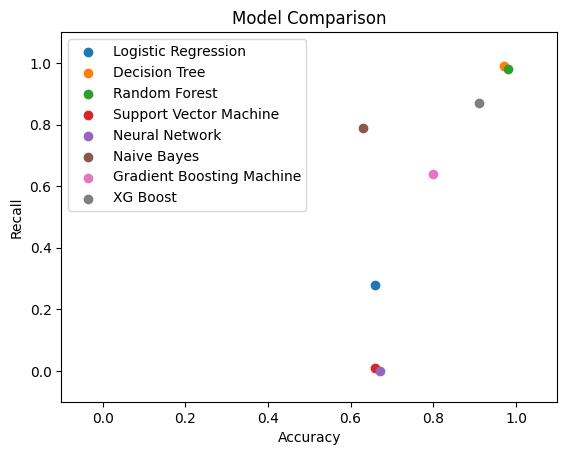

In [31]:
models = list(RESULTS.keys())

for model in models:
    plt.scatter(RESULTS[model]['accuracy'], RESULTS[model]['recall'], label=model)

plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Recall')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.legend()
plt.show()

### Conclusion
* The performance of 8 classification models was evaluated, and the Decision Tree and Random Forest models were found to have the highest recall and accuracy.
* However, these models have a relatively longer training and prediction time compared to other models.
* Naive Bayes and XG Boost classifiers were also evaluated and showed high recall value and faster performance than Decision Tree and Random Forest classifiers.
* Nonetheless, these models might compromise the accuracy of the predictions.
* GridSearchCV can be used to fine-tune the models' parameters and optimize their performance.
* By re-evaluating the models with new parameters, the optimal model can be selected based on its performance.
* This process can help to balance the trade-off between model accuracy, recall and computational efficiency.
* The selected model can then be further validated on a separate dataset to ensure its generalizability and effectiveness in real-world scenarios.